# Práctica Neo4j

## AUTORES
Alejandro Barrachina Argudo
Iñaki Berrocal Díaz

Partimos de un fichero con información de compras realizadas en unos grandes almacenes. La información que tenemos es:

 * tipo: representa el tipo de compras que realizó el cliente.
 * Sale_id: código de pedido
 * Weekday: el día de la semana de la compra
 * Product_id: número identificativo del producto comprado por el cliente.
 * Count: unidades que se han comprado
 * Department: departamento donde pertenece el artículo 
 * Product_category: categoría de los productos

Se desea reestructurar el supermercado, de forma que los productos que se suelen comprar a la vez, en el mismo pedido, se encuentren ubicados más cerca, para facilitar la compra del cliente. El objetivo es usar una BD orientada a grafo para intentar descubrir relaciones entre los distintos departamentos.

## Conexión con Neo4j en local

Usaremos el gestor de BBDD Neo4j. Trabajaremos en local. El primer paso es levantar el servidor. En el buscador de aplicaciones podemos escribir la cadena 'Neo4j". Seleccionar la aplicación Neo4j. Esto levanterá el servidor y aparecerá una terminal: 

<img src="./captura.PNG" alt="Supervisado" style="width: 700px;"/>



Aparecerá información para la conexión con el servidor y la url de la interfaz gráfica:
```
Bolt enabled on 127.0.0.1:7687
Remote interface available at http://localhost:7474/

```

## Abrir la interfaz gráfica


Escribir la url `http://localhost:7474/` en el navegador. 
```
usuario: neo4j
pwd: neo4j
```

Luego pedirá nueva pasword y confirmación.

Para conectarnos con Neo4j (en local) desde Python, necesitamos importar la librería `neo4j`. Si no la tienes instalada, puedes ejecutar la siguiente celda para instalarla:


In [1]:
# descomentar para instalar
#!pip install neo4j

In [2]:
from neo4j import GraphDatabase
from neo4j.exceptions import ServiceUnavailable

import pandas as pd
import time
import logging

La conexión con el servidor usa las credenciales:

In [3]:
NEO4J_URI = "bolt://localhost"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "usuario"   # pon tu pwd
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

session = driver.session()

## Carga de datos

In [4]:
# lectura de datos:
import pandas as pd
import numpy as np
import time

df = pd.read_csv("./sales.csv")
df

,tipo,Sale_id,Weekday,product_id,Count,Department,Product_category
0,999,171175,Thursday,2.840004e+09,1,IMPULSE MERCHANDISE,804.0
1,33,136704,Friday,7.033072e+09,1,PERSONAL CARE,1403.0
2,37,146456,Sunday,4.312000e+03,1,PRODUCE,5703.0
3,36,144414,Sunday,1.480065e+09,1,DSD GROCERY,4976.0
4,42,13371,Sunday,6.334723e+10,1,PHARMACY OTC,4601.0
...,...,...,...,...,...,...,...
3995,35,139178,Saturday,2.840000e+09,1,DSD GROCERY,9266.0
3996,40,190098,Sunday,7.341001e+09,1,COMM BREAD,3703.0
3997,40,81892,Thursday,7.290200e+09,1,PERSONAL CARE,5111.0
3998,40,163251,Wednesday,3.338365e+09,1,PRODUCE,7601.0


## Consultas

### Borrar la base de datos ( si es que no estuviera vacía)

Escribe las instrucciones necesarias para borrar todos los nodos y relaciones de la base de datos.

In [5]:
# SOL:
query = """
MATCH (n) DETACH DELETE n;
"""

session.run(query)


### Crear un nodo por cada departamento

Crear un nodo por cada uno de los departamentos de la tabla anterior. 
* Etiqueta de nodo: Departamento
* Propiedades de nodo: nombre

Crear un nodo por cada uno de los pedidos de la tabla anterior. 
* Etiqueta de nodo: Pedido
* Propiedades de nodo: 
    * id (sales_id)
    * day (día de la semana) 
    
Crear  una  relación entre pedidos y departamentos
* Etiqueta de arista : `SALE'
* Propiedades de arista: producto (se refiere al producto vendido)
    
__Pasos a seguir__

* Paso 1: Asegúrate de que no se crean nodos de tipo `Departamento` con el mismo `nombre` introduciendo una restricción de unicidad.

* Paso 2: Asegúrate de que no se crean nodos de tipo `Pedido` con el mismo `id` introduciendo una restricción de unicidad.

* Paso 3: Creación de los nodos `Departamento` y `Pedido`, y  la relación `SALE`.

Por ejemplo, se generará un subgrafo de la forma:
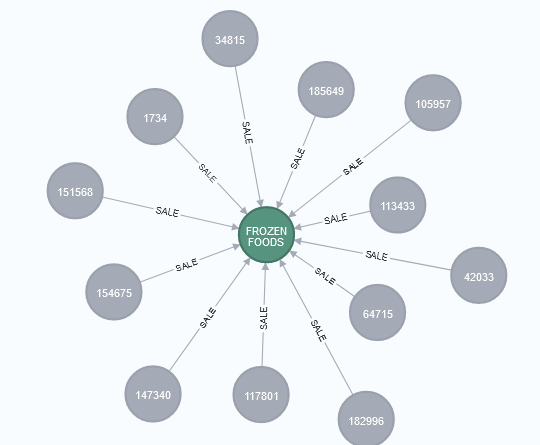
Los nodos verdes son los departamentos. Los nodos grises representan un pedido. Los arcos contienen la información del producto que se ha comprado en dicho pedido, el cual pertenece al departamento. Abre la interfaz gráfica de Neo4j y comprueba los resultados.

In [6]:
# Sol:
# creamos una restricción de unicidad
try:
    unique_show_id = "CREATE CONSTRAINT  FOR (d:Departamento) REQUIRE d.nombre IS UNIQUE"
    resultado = session.run(unique_show_id) # da error si ya existe la restricción
    
except:
    pass

In [7]:
# Sol
# ahora creamos los nodos
start_time = time.time()
count=df.shape[0]

request = """
MERGE (d:Departamento{nombre : $nombre})
MERGE (p:Pedido {id:$id, day : $day})
MERGE (p)-[sale:SALE]->(d)
"""
for index, row in df.iterrows():     # recorremos la tabla
    session.run(request,
                    nombre =    row['Department'],
                    id =      row['Sale_id'],
                    day = row['Weekday'],
                )
    if (index%500==0):
        exec_time = time.time() - start_time
        print(f'{index}/{df.shape[0]} done ... -- {exec_time} seconds --')

0/4000 done ... -- 0.4046459197998047 seconds --
500/4000 done ... -- 7.857776165008545 seconds --
1000/4000 done ... -- 13.097668647766113 seconds --
1500/4000 done ... -- 18.189334392547607 seconds --
2000/4000 done ... -- 23.785807371139526 seconds --
2500/4000 done ... -- 27.001028776168823 seconds --
3000/4000 done ... -- 31.982046127319336 seconds --
3500/4000 done ... -- 37.342312812805176 seconds --


### Calcula el número total de nodos de tipo 'Departamento' creados

In [8]:
# sol
q = 'MATCH (:Departamento) RETURN count(*) as count'
r = session.run(q)
r.value()

[58]

### Calcula el número total de nodos de tipo 'Pedido' creados

In [9]:
# sol
q = 'MATCH (:Pedido) RETURN count(*) as count'
r = session.run(q)
r.value()

[3785]

### Calcula el número total de aristas de tipo 'SALE' creadas

In [10]:
# sol
q = 'MATCH p=()-[r:SALE]->() RETURN count(*) as count'
r = session.run(q)
r.value()

[3960]

### ventas

¿En cuántos departamentos se vende cada uno de los pedidos?

In [11]:
# Sol:
q= """MATCH (p:Pedido)-[r:SALE]->(d:Departamento) 
with p, count(d) as count
RETURN p.id, count
"""
r= session.run(q)
for i in r:
    print(i['count'], i['p.id'])


1 161049
1 147933
1 72504
1 71332
1 14694
1 118666
1 171843
1 40109
1 118588
1 41980
1 50534
1 120870
1 149293
2 158390
1 48537
1 114517
1 83280
1 113936
1 133556
1 74597
1 62642
1 67251
1 19643
1 118034
1 90460
1 91197
1 106246
1 171990
1 79478
1 53840
1 118808
1 3974
1 74549
1 91772
1 59281
1 135088
1 163806
1 75517
1 74852
1 124993
1 9615
1 9125
1 141850
1 67269
1 71348
1 55146
1 10184
2 43142
1 109131
1 128087
1 131918
2 31989
2 121245
1 145303
1 98419
1 89152
2 50176
1 69174
1 117560
1 155409
1 18179
1 184723
1 73253
1 178276
1 15730
1 127483
1 83741
1 172158
1 158437
1 171162
1 185024
1 124168
1 183340
1 6467
1 19143
1 43911
1 170249
1 109770
1 110468
1 53991
1 53236
1 184958
1 181154
1 34632
1 73221
1 17928
1 134605
1 35372
1 66775
1 169653
1 88255
1 157738
1 10708
1 102638
1 48462
1 62334
1 140361
1 80852
1 168897
1 146905
1 93984
1 19052
1 58742
1 3642
1 68755
1 9962
1 98287
1 87865
1 182107
2 126633
1 67714
1 32882
1 132724
1 2619
1 137661
1 187539
1 148948
1 19119
2 99347
1 

### Compras realizadas los viernes

Visualiza los resultados en la interfaz gráfica.

In [12]:
# Sol
q = """
MATCH (p:Pedido)
WHERE p.day = "Friday"
return p.id
"""
r = session.run(q)
for e in r:
    print(e['p.id'])

136704
3912
175816
91576
43792
5816
46704
1439
133853
47979
89359
136019
87376
90598
131849
91754
133179
1220
177732
172891
135765
132790
173404
173036
92820
134524
136754
45048
133093
133346
92055
90397
134663
5460
130900
132445
46438
2819
133555
5798
2498
88829
457
47097
133188
8
87844
5558
176425
89967
131426
45435
91470
92989
48483
90203
177442
45516
133087
2742
45985
89143
90035
92236
44930
172387
135362
49029
177660
2534
1176
47667
92430
136135
5835
92597
173546
3258
135104
88308
135194
87975
88265
5233
177596
2070
136224
784
173007
92312
177658
46177
91971
87282
130947
88352
1201
130979
136697
44142
5351
177218
2603
3505
174894
176014
175993
49040
134521
89665
1718
43702
44671
175984
173559
133841
87591
5688
177096
44209
92146
133430
2046
175759
176530
44608
175117
134356
90412
3129
177622
135579
92173
136138
173236
176403
136271
136642
2406
89708
1195
5224
92933
173968
90221
136743
3973
44524
3433
90422
2208
92005
136664
47940
48796
176640
133440
91617
135668
90865
133276
3407


### Creación de relaciones entre departamentos

Si un pedido `p1` incluye un producto del departamento `D1` y un producto del departamento `D2`, podemos decir que ambos departamentos están ligados. Si es muy habitual que dos productos se vendan al mismo tiempo, sería conveniente detectar dicha información para ubicar dichos productos cerca dentro del supermercado.

Crear la relación entre departamentos a partir de la relación `SALE`.

* Etiqueta de arista : `LINKED'
* Propiedades de arista: `peso` 

El peso representa el número de pedidos distintos que con productos de los dos departamentos.
Sugnrencia: usar la operación `merge` a la hora de crear la relación `linked` con peso = 0. Posteriormente usar operación `set` para actuaalizar el valor de la propiedad peso con incremento 1.

In [18]:
# Sol:
request = """
MATCH (p)-[:SALE]->(d1)
MATCH (p)-[:SALE]->(d2)
where d1.nombre<>d2.nombre

MERGE (d1)-[m:LINKED {peso:0}]-(d2)
SET
m.peso = m.peso+1 
"""

session.run(request)

In [14]:
query = """
MATCH (d1)-[m:LINKED]-(d2) DETACH DELETE m;
"""

session.run(query)


### Calcular el mayor valor de la propiedad `peso`.

In [15]:
# sol
query= """MATCH (d1)-[m:LINKED]-(d2) RETURN MAX(m.peso) as Maximo"""

r = session.run(query)

print(r.value())

[None]


### Obtener de subgrafo 
Obtener el  subgrafo de los departamentos conectados cuyo peso sea superior a 5. Observa los resultados en la interfaz gráfica.
Intenta sacar conclusiones y describe brevemente.

In [16]:
query = """
MATCH subgrafo = (d1)-[m:LINKED]-(d2) – [ ] -> ( )
WHERE m.peso > 5
RETURN subgrafo
"""

### Obtener los departamentos no conectados con otros departamentos


In [17]:
# sol
query = """
MATCH (d:Departamento)
WHERE NOT (d)-[:LINKED]-(:Departamento)
return d.nombre;
"""

r = session.run(query)

for e in r:
    print(e['d.nombre'])

IMPULSE MERCHANDISE
PERSONAL CARE
PRODUCE
DSD GROCERY
PHARMACY OTC
BAKERY
MEAT - FRESH & FROZEN
BEAUTY
HOUSEHOLD CHEMICALS/SUPP
SERVICE DELI
LAWN AND GARDEN
DAIRY
GROCERY DRY GOODS
BOOKS AND MAGAZINES
HOME MANAGEMENT
FINANCIAL SERVICES
LADIESWEAR
CELEBRATION
HOME DECOR
LIQUOR,WINE,BEER
PETS AND SUPPLIES
PRE PACKED DELI
HORTICULTURE AND ACCESS
HOUSEHOLD PAPER GOODS
TOYS
SEAFOOD
OFFICE SUPPLIES
AUTOMOTIVE
FROZEN FOODS
BATH AND SHOWER
BRAS & SHAPEWEAR
ELECTRONICS
FABRICS AND CRAFTS
CANDY, TOBACCO, COOKIES
MENS WEAR
JEWELRY AND SUNGLASSES
COOK AND DINE
COMM BREAD
HARDWARE
SHOES
ACCESSORIES
SPORTING GOODS
PAINT AND ACCESSORIES
GIRLS WEAR, 4-6X  AND 7-14
BOYS WEAR
INFANT APPAREL
LADIES SOCKS
MENSWEAR
WIRELESS
MEDIA AND GAMING
SLEEPWEAR/FOUNDATIONS
BEDDING
SHEER HOSIERY
SWIMWEAR/OUTERWEAR
FURNITURE
1-HR PHOTO
PLUS AND MATERNITY
CONCEPT STORES
